In [1]:
import pandas as pd
import numpy as np
import statsmodels.api as sm
from tqdm import tqdm
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from statsmodels.tsa.statespace.sarimax import SARIMAX
import warnings
import itertools
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import mean_squared_error



df = pd.read_csv('/Users/markuswiikjensen/Desktop/Master-Data/Final_data/elspot_prices_dt_interpolated.csv')
df.drop(df.loc[df['datetime'].duplicated()].index, inplace = True)
df['datetime'] = pd.to_datetime(df['datetime'])

# df = df.sort_values(df['datetime'], ascending=[True])


df.set_index(df['datetime'], inplace = True)
last_date = df['datetime'] < '2023-04-01 00:00:00'
df = df[last_date]

df.drop(columns = [ 'datetime','Unnamed: 0'], inplace = True)

df

,Oslo,Kr.sand,Bergen,Molde,Tr.heim,TromsÃ¸
datetime,,,,,,
2020-01-01 00:00:00,31386.0,31386.0,31386.0,28387.0,28387.0,28387.0
2020-01-01 01:00:00,31336.0,31336.0,31336.0,28062.0,28062.0,28062.0
2020-01-01 02:00:00,31139.0,31139.0,31139.0,27519.0,27519.0,27519.0
2020-01-01 03:00:00,30853.0,30853.0,30853.0,27144.0,27144.0,27144.0
2020-01-01 04:00:00,30301.0,30301.0,30301.0,27164.0,27164.0,27164.0
...,...,...,...,...,...,...
2023-03-31 19:00:00,118638.0,118638.0,118638.0,74475.0,74475.0,35008.0
2023-03-31 20:00:00,115541.0,115541.0,115541.0,74520.0,74520.0,35008.0
2023-03-31 21:00:00,108281.0,108281.0,108281.0,75882.0,75882.0,35008.0


In [2]:
from numpy import inf

def mean_absolute_percentage_error(y_true, y_pred):
    y_true, y_pred = np.array(y_true), np.array(y_pred)
    difference = abs((y_true - y_pred))
    difference[difference == inf] = 0.01
    difference[difference == -inf] = 0.01
    difference[difference == 0] = 0.01
    y_true[y_true == 0] = 0.01
    return np.mean((difference/y_true) * 100)

In [3]:
def prepare_data(target):
    steps=24
    dataset_for_prediction= df.copy()
    dataset_for_prediction=dataset_for_prediction.drop(columns = [column for column in dataset_for_prediction.columns if column not in target])
    dataset_for_prediction['Price']=dataset_for_prediction[target]
    dataset_for_prediction['Target']= dataset_for_prediction[target].shift(-steps)
    dataset_for_prediction=dataset_for_prediction.drop([target], 1)
    dataset_for_prediction=dataset_for_prediction.dropna()

    train_set = dataset_for_prediction[:365*24*3] 
    test_set = dataset_for_prediction[365*24*3:] 

    
    # split the data into input (X) and output (y)
    train_X = train_set.drop('Target', axis=1).values
    train_y = train_set['Target'].values
    test_X = test_set.drop('Target', axis=1).values
    test_y = test_set['Target'].values

    # apply min-max scaling to the input and output data
    scaler_X = MinMaxScaler(feature_range=(-1, 1))
    train_X = scaler_X.fit_transform(train_X)
    test_X = scaler_X.transform(test_X)

    scaler_y = MinMaxScaler(feature_range=(-1, 1))
    train_y = scaler_y.fit_transform(train_y.reshape(-1, 1))
    test_y = scaler_y.transform(test_y.reshape(-1, 1))

    return train_X, train_y, test_X, test_y, scaler_X, scaler_y,  train_set, test_set


# Oslo

In [4]:
train_X, train_y, test_X, test_y, scaler_X, scaler_y,  train_set, test_set =prepare_data('Oslo')

/var/folders/qt/z8wfyvqx1l55qqc_y_5n83fc0000gn/T/ipykernel_42983/3823730648.py:7: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only.
  dataset_for_prediction=dataset_for_prediction.drop([target], 1)


In [5]:
train_X

array([[-0.9149036 ],
       [-0.91503115],
       [-0.9155337 ],
       ...,
       [-0.70960899],
       [-0.77752183],
       [-0.99020925]])

## Find the optimal order for(p,d,q)

In [6]:
import statsmodels.api as sm
import itertools
import warnings
warnings.filterwarnings("ignore")


# Define the range of p, d, and q values to use
p = range(0, 3)
d = range(0, 2)
q = range(0, 3)

# Generate all possible combinations of p, d, and q values
pdq = list(itertools.product(p, d, q))

# Define an empty dictionary to store the BIC and AIC values for each model
results = {}

# Iterate over all possible combinations of p, d, and q values
for order in tqdm(pdq):
    try:
        # Fit the model
        model = sm.tsa.statespace.SARIMAX(train_X, order=order, enforce_stationarity=False, enforce_invertibility=False)
        results_fit = model.fit(disp=False)

        # Calculate the BIC and AIC values
        bic = results_fit.bic
        aic = results_fit.aic

        # Store the BIC and AIC values for this model
        results[order] = {'bic': bic, 'aic': aic}
    except:
        continue

# Find the order with the lowest BIC value
best_bic = min(results, key=lambda k: results[k]['bic'])
print(f'Best BIC: {best_bic} ({results[best_bic]["bic"]:.2f})')

# Find the order with the lowest AIC value
best_aic = min(results, key=lambda k: results[k]['aic'])
print(f'Best AIC: {best_aic} ({results[best_aic]["aic"]:.2f})')


100%|███████████████████████████████████████████| 18/18 [00:22<00:00,  1.25s/it]

Best BIC: (2, 1, 2) (-104516.76)
Best AIC: (2, 1, 2) (-104557.64)


In [7]:
import warnings
warnings.filterwarnings("ignore")
from sklearn.model_selection import TimeSeriesSplit

tscv = TimeSeriesSplit(n_splits=365, test_size=24)
val_preds=[]
rmse=[]
mape=[]
mae=[]
forecast=pd.Series()
for train_index, val_index in tqdm(tscv.split(train_X)):
    X_train, X_val = train_X[train_index], train_X[val_index]
    y_val = train_y[val_index]
    model = sm.tsa.statespace.SARIMAX(X_train,
                                      order=(2, 1, 2),
                                      enforce_stationarity=False,
                                      enforce_invertibility=False)
    results = model.fit(disp=False)
    preds = results.forecast(steps=len(X_val))

    # invert scaling to get unscaled predictions
    preds = preds.reshape(-1, 1)
    preds = scaler_y.inverse_transform(preds)

    y_val = np.array(y_val).reshape(-1, 1)
    y_val = scaler_y.inverse_transform(y_val)
    
    forecast = pd.concat([forecast, pd.Series(preds.ravel())])
    val_preds.append(preds)
    mape.append(np.mean(np.abs((y_val - preds) / y_val)) * 100)
    rmse.append(np.sqrt(mean_squared_error(y_val, preds)))
    mae.append(mean_absolute_error(y_val, preds))

365it [16:10,  2.66s/it]


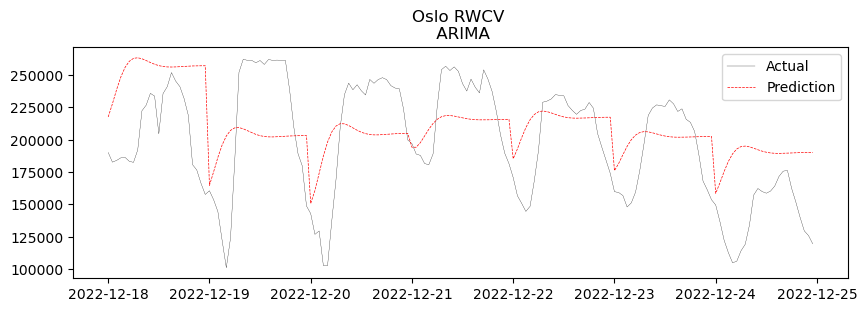

In [8]:

train_set.index.freq = 'H'

shifted_index = train_set.index[-24*13:-24*6]

# Plot the data
plt.figure(figsize=(10, 3))
plt.plot(shifted_index.values, train_set['Price'][(-24*13):(-24*6)].values, label='Actual', linewidth=0.2,  c='black')
plt.plot(shifted_index.values, forecast[(-24*13):(-24*6)], label='Prediction', linewidth=0.5, linestyle='--', c='r')
plt.title('Oslo RWCV \n ARIMA')
plt.legend()
plt.show()


In [9]:
# Calculate and print errors

# compute the residuals
residuals = train_set['Target'][365*24*2:].values - val_preds

# compute the RSS
rss = np.sum(residuals**2)

print("Residual Sum of Squares (RSS): ", rss)
print("Mean RMSE:", np.mean(rmse))
print("Mean MAPE:", np.mean(mape))
print("Mean MAE:", np.mean(mae))

Residual Sum of Squares (RSS):  1.7046774794187965e+18
Mean RMSE: 43970.16452313796
Mean MAPE: 193.74989524304814
Mean MAE: 37346.419958808365


In [10]:
morning_mask = (train_set.iloc[-365*24:].index.hour >= 6) & (train_set.iloc[-365*24:].index.hour < 12)
midday_mask = (train_set.iloc[-365*24:].index.hour >= 12) & (train_set.iloc[-365*24:].index.hour < 15)
evening_mask = (train_set.iloc[-365*24:].index.hour >= 15) & (train_set.iloc[-365*24:].index.hour < 21)
night_mask = (train_set.iloc[-365*24:].index.hour >= 21) | (train_set.iloc[-365*24:].index.hour < 6)

preds=pd.Series(forecast.values, index=train_set.iloc[-365*24:].index.values)
actual= pd.Series(train_set.iloc[-365*24:]['Target'].values, index=train_set.iloc[-365*24:].index.values)

rmse_morning_scores= np.sqrt(mean_squared_error(actual[morning_mask], preds[morning_mask]))
rmse_morning_scores

rmse_midday_scores= np.sqrt(mean_squared_error(actual[midday_mask], preds[midday_mask]))
rmse_midday_scores

rmse_evening_scores= np.sqrt(mean_squared_error(actual[evening_mask], preds[evening_mask]))
rmse_evening_scores

rmse_night_scores= np.sqrt(mean_squared_error(actual[night_mask], preds[night_mask]))
rmse_night_scores

rmse_scores=pd.Series((rmse_morning_scores,rmse_midday_scores,rmse_evening_scores, rmse_night_scores))


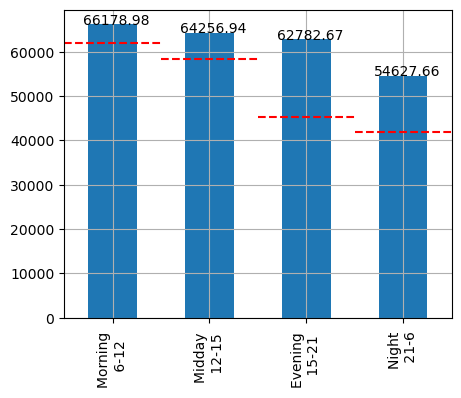

In [11]:
rmse_scores.plot(kind='bar', figsize=(5,4), grid=True)
plt.xticks(ticks=(0, 1, 2, 3), labels=('Morning \n 6-12', 'Midday \n 12-15', 'Evening \n 15-21', 'Night \n 21-6'))

# Annotate the RMSE scores on the bar chart
for i, v in enumerate(rmse_scores):
    plt.annotate(str(round(v,2)), xy=(i-0.3, v))
    
for i, v in enumerate(rmse_scores):
    if i == 0:
        plt.axhline(y=62023, color='r', linestyle='--', xmin=i / len(rmse_scores), xmax=(i + 1) / len(rmse_scores))
    elif i == 1:
        plt.axhline(y=58327, color='r', linestyle='--', xmin=i / len(rmse_scores), xmax=(i + 1) / len(rmse_scores))
    elif i == 2:
        plt.axhline(y=45331, color='r', linestyle='--', xmin=i / len(rmse_scores), xmax=(i + 1) / len(rmse_scores))
    elif i == 3:
        plt.axhline(y=41924, color='r', linestyle='--', xmin=i / len(rmse_scores), xmax=(i + 1) / len(rmse_scores))
    

plt.show()

In [12]:
mae_morning_scores = mean_absolute_error(actual[morning_mask], preds[morning_mask])
mae_midday_scores = mean_absolute_error(actual[midday_mask], preds[midday_mask])
mae_evening_scores = mean_absolute_error(actual[evening_mask], preds[evening_mask])
mae_night_scores = mean_absolute_error(actual[night_mask], preds[night_mask])

mae_scores = pd.Series((mae_morning_scores, mae_midday_scores, mae_evening_scores, mae_night_scores))


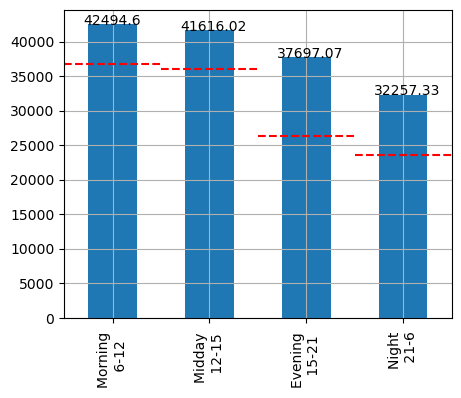

In [13]:
mae_scores.plot(kind='bar', figsize=(5,4), grid=True)
plt.xticks(ticks=(0, 1, 2, 3), labels=('Morning \n 6-12', 'Midday \n 12-15', 'Evening \n 15-21', 'Night \n 21-6'))

# Annotate the RMSE scores on the bar chart
for i, v in enumerate(mae_scores):
    plt.annotate(str(round(v,2)), xy=(i-0.3, v))
    
for i, v in enumerate(mae_scores):
    if i == 0:
        plt.axhline(y=36809, color='r', linestyle='--', xmin=i / len(mae_scores), xmax=(i + 1) / len(mae_scores))
    elif i == 1:
        plt.axhline(y=36069, color='r', linestyle='--', xmin=i / len(mae_scores), xmax=(i + 1) / len(mae_scores))
    elif i == 2:
        plt.axhline(y=26361, color='r', linestyle='--', xmin=i / len(mae_scores), xmax=(i + 1) / len(mae_scores))
    elif i == 3:
        plt.axhline(y=23577, color='r', linestyle='--', xmin=i / len(mae_scores), xmax=(i + 1) / len(mae_scores))


plt.show()

Residual Sum of Squares (RSS):  1875915370136.5059
RMSE: 29469.9735, MAPE: 25.1861% , MAE:  19946.0102, RSS:  1875915370136.5059


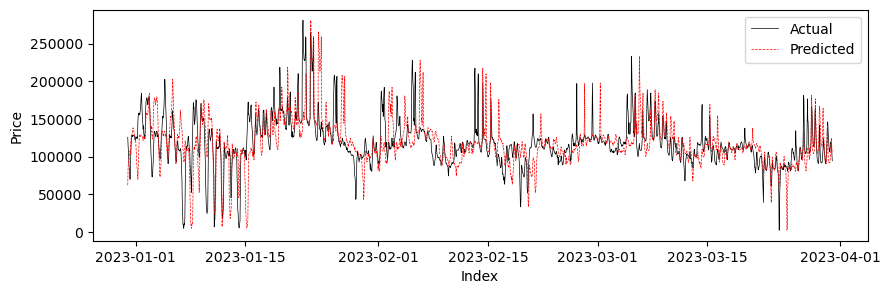

In [14]:
model = sm.tsa.statespace.SARIMAX(train_X, exog=train_X, 
                                  order=(2, 1, 2),
                                  enforce_stationarity=False,
                                  enforce_invertibility=False)
results = model.fit(disp=False)
preds = results.forecast(steps=len(test_X), exog=test_X)


# invert scaling to get unscaled predictions
preds = preds.reshape(-1, 1)
preds = scaler_y.inverse_transform(preds)

test_y = np.array(test_y).reshape(-1, 1)
test_y = scaler_y.inverse_transform(test_y)

# calculate RMSE and MAPE
rmse = np.sqrt(mean_squared_error(test_y, preds))
mape = np.mean(np.abs((test_y - preds) / test_y)) * 100
mae= mean_absolute_error(test_y, preds)

# compute the residuals
residuals = test_y - preds

# compute the RSS
rss = np.sum(residuals**2)

print("Residual Sum of Squares (RSS): ", rss)

print(f'RMSE: {rmse:.4f}, MAPE: {mape:.4f}% , MAE: {mae: .4f}, RSS: {rss: .4f}')

# plot actual vs predicted values
plt.figure(figsize=(10, 3))
plt.plot(test_set.index, test_y, label='Actual', linewidth=0.5, c='black')
plt.plot(test_set.index, preds, label='Predicted', linewidth=0.5, linestyle='--', c='r')

plt.xlabel('Index')
plt.ylabel('Price')
plt.legend()
plt.show()


# Kr.sand

In [15]:
train_X, train_y, test_X, test_y, scaler_X, scaler_y,  train_set, test_set =prepare_data('Kr.sand')

In [16]:
train_X

array([[-0.9190767 ],
       [-0.919198  ],
       [-0.9196759 ],
       ...,
       [-0.72384967],
       [-0.78843208],
       [-0.99068938]])

In [17]:
import warnings
warnings.filterwarnings("ignore")
from sklearn.model_selection import TimeSeriesSplit

tscv = TimeSeriesSplit(n_splits=365, test_size=24)
val_preds=[]
rmse=[]
mape=[]
mae=[]
forecast=pd.Series()
for train_index, val_index in tqdm(tscv.split(train_X)):
    X_train, X_val = train_X[train_index], train_X[val_index]
    y_val = train_y[val_index]
    model = sm.tsa.statespace.SARIMAX(X_train,
                                      order=(2, 1, 2),
                                      enforce_stationarity=False,
                                      enforce_invertibility=False)
    results = model.fit(disp=False)
    preds = results.forecast(steps=len(X_val))

    # invert scaling to get unscaled predictions
    preds = preds.reshape(-1, 1)
    preds = scaler_y.inverse_transform(preds)

    y_val = np.array(y_val).reshape(-1, 1)
    y_val = scaler_y.inverse_transform(y_val)
    
    forecast = pd.concat([forecast, pd.Series(preds.ravel())])
    val_preds.append(preds)
    mape.append(np.mean(np.abs((y_val - preds) / y_val)) * 100)
    rmse.append(np.sqrt(mean_squared_error(y_val, preds)))
    mae.append(mean_absolute_error(y_val, preds))

365it [18:02,  2.96s/it]


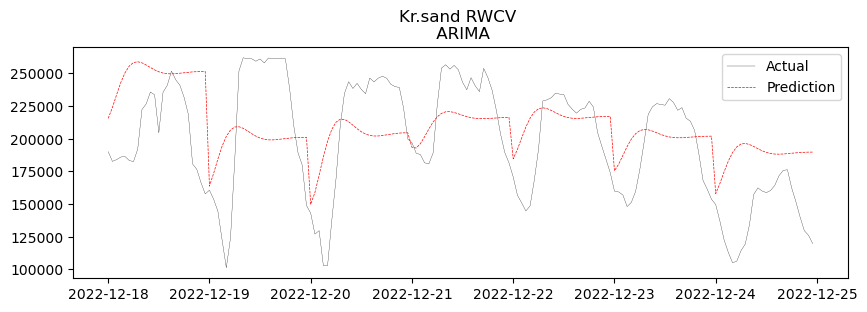

In [18]:

train_set.index.freq = 'H'

shifted_index = train_set.index[-24*13:-24*6]

# Plot the data
plt.figure(figsize=(10, 3))
plt.plot(shifted_index.values, train_set['Price'][(-24*13):(-24*6)].values, label='Actual', linewidth=0.2,  c='black')
plt.plot(shifted_index.values, forecast[(-24*13):(-24*6)], label='Prediction', linewidth=0.5, linestyle='--', c='r')
plt.title('Kr.sand RWCV \n ARIMA')
plt.legend()
plt.show()



In [19]:
# Calculate and print errors

# compute the residuals
residuals = train_set['Target'][365*24*2:].values - val_preds

# compute the RSS
rss = np.sum(residuals**2)

print("Residual Sum of Squares (RSS): ", rss)
print("Mean RMSE:", np.mean(rmse))
print("Mean MAPE:", np.mean(mape))
print("Mean MAE:", np.mean(mae))

Residual Sum of Squares (RSS):  2.2389732554478464e+18
Mean RMSE: 52832.82374299447
Mean MAPE: 194.9787895393908
Mean MAE: 45122.78019489285


In [20]:
morning_mask = (train_set.iloc[-365*24:].index.hour >= 6) & (train_set.iloc[-365*24:].index.hour < 12)
midday_mask = (train_set.iloc[-365*24:].index.hour >= 12) & (train_set.iloc[-365*24:].index.hour < 15)
evening_mask = (train_set.iloc[-365*24:].index.hour >= 15) & (train_set.iloc[-365*24:].index.hour < 21)
night_mask = (train_set.iloc[-365*24:].index.hour >= 21) | (train_set.iloc[-365*24:].index.hour < 6)

preds=pd.Series(forecast.values, index=train_set.iloc[-365*24:].index.values)
actual= pd.Series(train_set.iloc[-365*24:]['Target'].values, index=train_set.iloc[-365*24:].index.values)

rmse_morning_scores= np.sqrt(mean_squared_error(actual[morning_mask], preds[morning_mask]))
rmse_morning_scores

rmse_midday_scores= np.sqrt(mean_squared_error(actual[midday_mask], preds[midday_mask]))
rmse_midday_scores

rmse_evening_scores= np.sqrt(mean_squared_error(actual[evening_mask], preds[evening_mask]))
rmse_evening_scores

rmse_night_scores= np.sqrt(mean_squared_error(actual[night_mask], preds[night_mask]))
rmse_night_scores

rmse_scores=pd.Series((rmse_morning_scores,rmse_midday_scores,rmse_evening_scores, rmse_night_scores))


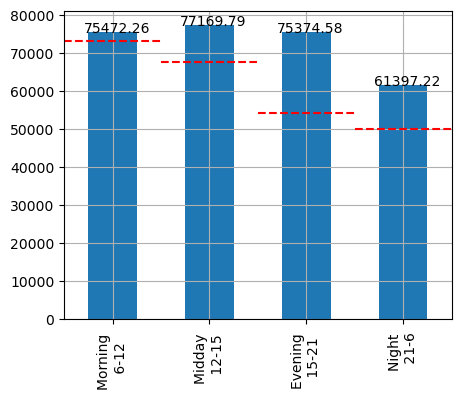

In [21]:
rmse_scores.plot(kind='bar', figsize=(5,4), grid=True)
plt.xticks(ticks=(0, 1, 2, 3), labels=('Morning \n 6-12', 'Midday \n 12-15', 'Evening \n 15-21', 'Night \n 21-6'))

# Annotate the RMSE scores on the bar chart
for i, v in enumerate(rmse_scores):
    plt.annotate(str(round(v,2)), xy=(i-0.3, v))

for i, v in enumerate(rmse_scores):
    if i == 0:
        plt.axhline(y=73173, color='r', linestyle='--', xmin=i / len(rmse_scores), xmax=(i + 1) / len(rmse_scores))
    elif i == 1:
        plt.axhline(y=67576, color='r', linestyle='--', xmin=i / len(rmse_scores), xmax=(i + 1) / len(rmse_scores))
    elif i == 2:
        plt.axhline(y=53986, color='r', linestyle='--', xmin=i / len(rmse_scores), xmax=(i + 1) / len(rmse_scores))
    elif i == 3:
        plt.axhline(y=49911, color='r', linestyle='--', xmin=i / len(rmse_scores), xmax=(i + 1) / len(rmse_scores))
    

plt.show()

In [22]:
mae_morning_scores = mean_absolute_error(actual[morning_mask], preds[morning_mask])
mae_midday_scores = mean_absolute_error(actual[midday_mask], preds[midday_mask])
mae_evening_scores = mean_absolute_error(actual[evening_mask], preds[evening_mask])
mae_night_scores = mean_absolute_error(actual[night_mask], preds[night_mask])

mae_scores = pd.Series((mae_morning_scores, mae_midday_scores, mae_evening_scores, mae_night_scores))


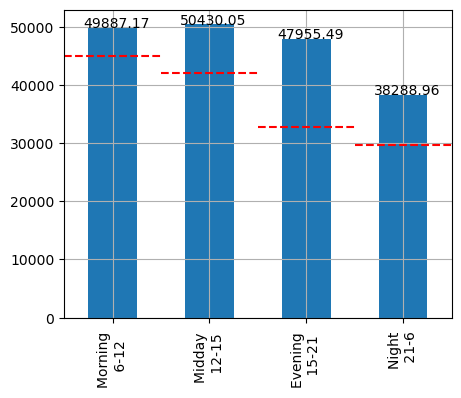

In [23]:
mae_scores.plot(kind='bar', figsize=(5,4), grid=True)
plt.xticks(ticks=(0, 1, 2, 3), labels=('Morning \n 6-12', 'Midday \n 12-15', 'Evening \n 15-21', 'Night \n 21-6'))

# Annotate the RMSE scores on the bar chart
for i, v in enumerate(mae_scores):
    plt.annotate(str(round(v,2)), xy=(i-0.3, v))

for i, v in enumerate(mae_scores):
    if i == 0:
        plt.axhline(y=44972, color='r', linestyle='--', xmin=i / len(mae_scores), xmax=(i + 1) / len(mae_scores))
    elif i == 1:
        plt.axhline(y=42098, color='r', linestyle='--', xmin=i / len(mae_scores), xmax=(i + 1) / len(mae_scores))
    elif i == 2:
        plt.axhline(y=32833, color='r', linestyle='--', xmin=i / len(mae_scores), xmax=(i + 1) / len(mae_scores))
    elif i == 3:
        plt.axhline(y=29745, color='r', linestyle='--', xmin=i / len(mae_scores), xmax=(i + 1) / len(mae_scores))


plt.show()

Residual Sum of Squares (RSS):  1876445092082.511
RMSE: 29474.1341, MAPE: 25.1852% , MAE:  19943.6204, RSS:  1876445092082.5110


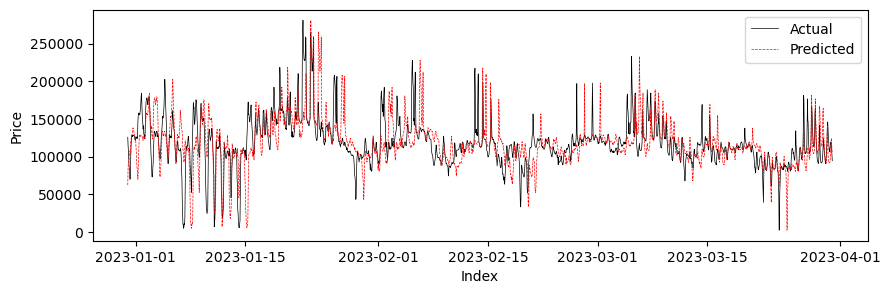

In [24]:
model = sm.tsa.statespace.SARIMAX(train_X, exog=train_X, 
                                  order=(2, 1, 2),
                                  enforce_stationarity=False,
                                  enforce_invertibility=False)
results = model.fit(disp=False)
preds = results.forecast(steps=len(test_X), exog=test_X)


# invert scaling to get unscaled predictions
preds = preds.reshape(-1, 1)
preds = scaler_y.inverse_transform(preds)

test_y = np.array(test_y).reshape(-1, 1)
test_y = scaler_y.inverse_transform(test_y)

# calculate RMSE and MAPE
rmse = np.sqrt(mean_squared_error(test_y, preds))
mape = np.mean(np.abs((test_y - preds) / test_y)) * 100
mae= mean_absolute_error(test_y, preds)

# compute the residuals
residuals = test_y - preds

# compute the RSS
rss = np.sum(residuals**2)

print("Residual Sum of Squares (RSS): ", rss)

print(f'RMSE: {rmse:.4f}, MAPE: {mape:.4f}% , MAE: {mae: .4f}, RSS: {rss: .4f}')

# plot actual vs predicted values
plt.figure(figsize=(10, 3))
plt.plot(test_set.index, test_y, label='Actual', linewidth=0.5, c='black')
plt.plot(test_set.index, preds, label='Predicted', linewidth=0.5, linestyle='--', c='r')

plt.xlabel('Index')
plt.ylabel('Price')
plt.legend()
plt.show()


# Bergen

In [25]:
train_X, train_y, test_X, test_y, scaler_X, scaler_y,  train_set, test_set =prepare_data('Bergen')

In [26]:
train_X

array([[-0.91949666],
       [-0.91962451],
       [-0.92012827],
       ...,
       [-0.71370963],
       [-0.78178536],
       [-0.81284162]])

In [27]:
import warnings
warnings.filterwarnings("ignore")
from sklearn.model_selection import TimeSeriesSplit

tscv = TimeSeriesSplit(n_splits=365, test_size=24)
val_preds=[]
rmse=[]
mape=[]
mae=[]
forecast=pd.Series()
for train_index, val_index in tqdm(tscv.split(train_X)):
    X_train, X_val = train_X[train_index], train_X[val_index]
    y_val = train_y[val_index]
    model = sm.tsa.statespace.SARIMAX(X_train,
                                      order=(2, 1, 2),
                                      enforce_stationarity=False,
                                      enforce_invertibility=False)
    results = model.fit(disp=False)
    preds = results.forecast(steps=len(X_val))

    # invert scaling to get unscaled predictions
    preds = preds.reshape(-1, 1)
    preds = scaler_y.inverse_transform(preds)

    y_val = np.array(y_val).reshape(-1, 1)
    y_val = scaler_y.inverse_transform(y_val)
    
    forecast = pd.concat([forecast, pd.Series(preds.ravel())])
    val_preds.append(preds)
    mape.append(np.mean(np.abs((y_val - preds) / y_val)) * 100)
    rmse.append(np.sqrt(mean_squared_error(y_val, preds)))
    mae.append(mean_absolute_error(y_val, preds))

365it [17:05,  2.81s/it]


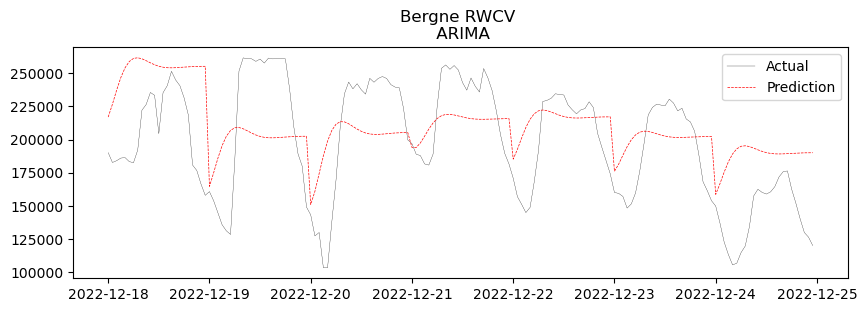

In [28]:

train_set.index.freq = 'H'

shifted_index = train_set.index[-24*13:-24*6]
# Plot the data
plt.figure(figsize=(10, 3))
plt.plot(shifted_index.values, train_set['Price'][(-24*13):(-24*6)].values, label='Actual', linewidth=0.2,  c='black')
plt.plot(shifted_index.values, forecast[(-24*13):(-24*6)], label='Prediction', linewidth=0.5, linestyle='--', c='r')
plt.title('Bergen RWCV \n ARIMA')
plt.legend()
plt.show()



In [29]:
# Calculate and print errors

# compute the residuals
residuals = train_set['Target'][365*24*2:].values - val_preds

# compute the RSS
rss = np.sum(residuals**2)

print("Residual Sum of Squares (RSS): ", rss)
print("Mean RMSE:", np.mean(rmse))
print("Mean MAPE:", np.mean(mape))
print("Mean MAE:", np.mean(mae))

Residual Sum of Squares (RSS):  1.6941964041507994e+18
Mean RMSE: 42755.40458936742
Mean MAPE: 191.59755580292006
Mean MAE: 36593.55710354662


In [30]:
morning_mask = (train_set.iloc[-365*24:].index.hour >= 6) & (train_set.iloc[-365*24:].index.hour < 12)
midday_mask = (train_set.iloc[-365*24:].index.hour >= 12) & (train_set.iloc[-365*24:].index.hour < 15)
evening_mask = (train_set.iloc[-365*24:].index.hour >= 15) & (train_set.iloc[-365*24:].index.hour < 21)
night_mask = (train_set.iloc[-365*24:].index.hour >= 21) | (train_set.iloc[-365*24:].index.hour < 6)

preds=pd.Series(forecast.values, index=train_set.iloc[-365*24:].index.values)
actual= pd.Series(train_set.iloc[-365*24:]['Target'].values, index=train_set.iloc[-365*24:].index.values)

rmse_morning_scores= np.sqrt(mean_squared_error(actual[morning_mask], preds[morning_mask]))
rmse_morning_scores

rmse_midday_scores= np.sqrt(mean_squared_error(actual[midday_mask], preds[midday_mask]))
rmse_midday_scores

rmse_evening_scores= np.sqrt(mean_squared_error(actual[evening_mask], preds[evening_mask]))
rmse_evening_scores

rmse_night_scores= np.sqrt(mean_squared_error(actual[night_mask], preds[night_mask]))
rmse_night_scores

rmse_scores=pd.Series((rmse_morning_scores,rmse_midday_scores,rmse_evening_scores, rmse_night_scores))


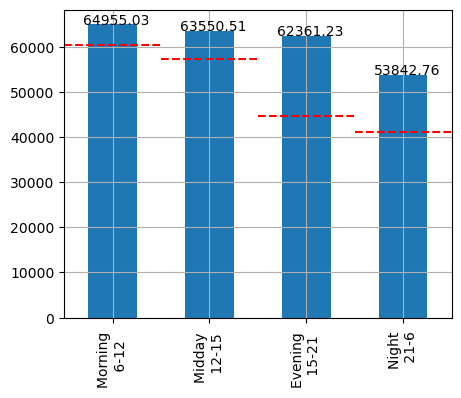

In [31]:
rmse_scores.plot(kind='bar', figsize=(5,4), grid=True)
plt.xticks(ticks=(0, 1, 2, 3), labels=('Morning \n 6-12', 'Midday \n 12-15', 'Evening \n 15-21', 'Night \n 21-6'))

# Annotate the RMSE scores on the bar chart
for i, v in enumerate(rmse_scores):
    plt.annotate(str(round(v,2)), xy=(i-0.3, v))
    
for i, v in enumerate(rmse_scores):
    if i == 0:
        plt.axhline(y=60297, color='r', linestyle='--', xmin=i / len(rmse_scores), xmax=(i + 1) / len(rmse_scores))
    elif i == 1:
        plt.axhline(y=57312, color='r', linestyle='--', xmin=i / len(rmse_scores), xmax=(i + 1) / len(rmse_scores))
    elif i == 2:
        plt.axhline(y=44719, color='r', linestyle='--', xmin=i / len(rmse_scores), xmax=(i + 1) / len(rmse_scores))
    elif i == 3:
        plt.axhline(y=41079, color='r', linestyle='--', xmin=i / len(rmse_scores), xmax=(i + 1) / len(rmse_scores))
    
    

plt.show()

In [32]:
mae_morning_scores = mean_absolute_error(actual[morning_mask], preds[morning_mask])
mae_midday_scores = mean_absolute_error(actual[midday_mask], preds[midday_mask])
mae_evening_scores = mean_absolute_error(actual[evening_mask], preds[evening_mask])
mae_night_scores = mean_absolute_error(actual[night_mask], preds[night_mask])

mae_scores = pd.Series((mae_morning_scores, mae_midday_scores, mae_evening_scores, mae_night_scores))


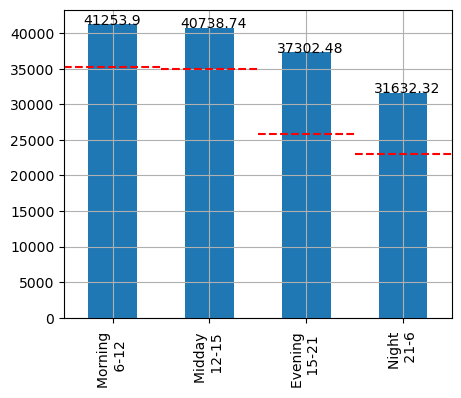

In [33]:
mae_scores.plot(kind='bar', figsize=(5,4), grid=True)
plt.xticks(ticks=(0, 1, 2, 3), labels=('Morning \n 6-12', 'Midday \n 12-15', 'Evening \n 15-21', 'Night \n 21-6'))

# Annotate the RMSE scores on the bar chart
for i, v in enumerate(mae_scores):
    plt.annotate(str(round(v,2)), xy=(i-0.3, v))
    
    
for i, v in enumerate(mae_scores):
    if i == 0:
        plt.axhline(y=35282, color='r', linestyle='--', xmin=i / len(mae_scores), xmax=(i + 1) / len(mae_scores))
    elif i == 1:
        plt.axhline(y=35024, color='r', linestyle='--', xmin=i / len(mae_scores), xmax=(i + 1) / len(mae_scores))
    elif i == 2:
        plt.axhline(y=25820, color='r', linestyle='--', xmin=i / len(mae_scores), xmax=(i + 1) / len(mae_scores))
    elif i == 3:
        plt.axhline(y=23032, color='r', linestyle='--', xmin=i / len(mae_scores), xmax=(i + 1) / len(mae_scores))



plt.show()

Residual Sum of Squares (RSS):  1376115746374.5093
RMSE: 25240.6542, MAPE: 15.7512% , MAE:  16953.1231, RSS:  1376115746374.5093


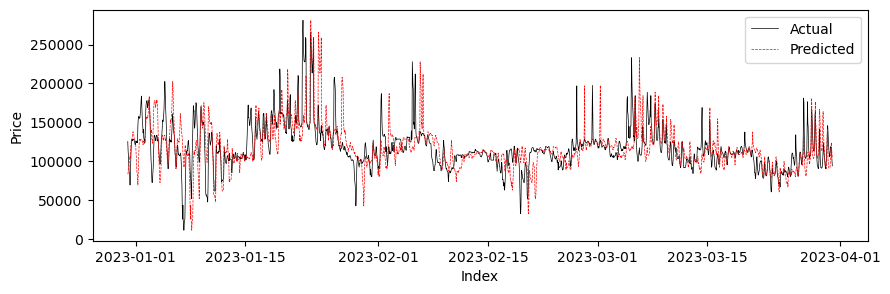

In [34]:
model = sm.tsa.statespace.SARIMAX(train_X, exog=train_X, 
                                  order=(2, 1, 2),
                                  enforce_stationarity=False,
                                  enforce_invertibility=False)
results = model.fit(disp=False)
preds = results.forecast(steps=len(test_X), exog=test_X)


# invert scaling to get unscaled predictions
preds = preds.reshape(-1, 1)
preds = scaler_y.inverse_transform(preds)

test_y = np.array(test_y).reshape(-1, 1)
test_y = scaler_y.inverse_transform(test_y)

# calculate RMSE and MAPE
rmse = np.sqrt(mean_squared_error(test_y, preds))
mape = np.mean(np.abs((test_y - preds) / test_y)) * 100
mae= mean_absolute_error(test_y, preds)

# compute the residuals
residuals = test_y - preds

# compute the RSS
rss = np.sum(residuals**2)

print("Residual Sum of Squares (RSS): ", rss)

print(f'RMSE: {rmse:.4f}, MAPE: {mape:.4f}% , MAE: {mae: .4f}, RSS: {rss: .4f}')

# plot actual vs predicted values
plt.figure(figsize=(10, 3))
plt.plot(test_set.index, test_y, label='Actual', linewidth=0.5, c='black')
plt.plot(test_set.index, preds, label='Predicted', linewidth=0.5, linestyle='--', c='r')

plt.xlabel('Index')
plt.ylabel('Price')
plt.legend()
plt.show()


# Molde

In [35]:
train_X, train_y, test_X, test_y, scaler_X, scaler_y,  train_set, test_set =prepare_data('Molde')

In [36]:
train_X

array([[-0.90148957],
       [-0.90253844],
       [-0.90429087],
       ...,
       [-0.91317566],
       [-0.91351775],
       [-0.91413094]])

In [37]:
import statsmodels.api as sm
import itertools
import warnings
warnings.filterwarnings("ignore")


# Define the range of p, d, and q values to use
p = range(0, 3)
d = range(0, 2)
q = range(0, 3)

# Generate all possible combinations of p, d, and q values
pdq = list(itertools.product(p, d, q))

# Define an empty dictionary to store the BIC and AIC values for each model
results = {}

# Iterate over all possible combinations of p, d, and q values
for order in tqdm(pdq):
    try:
        # Fit the model
        model = sm.tsa.statespace.SARIMAX(train_X, order=order, enforce_stationarity=False, enforce_invertibility=False)
        results_fit = model.fit(disp=False)

        # Calculate the BIC and AIC values
        bic = results_fit.bic
        aic = results_fit.aic

        # Store the BIC and AIC values for this model
        results[order] = {'bic': bic, 'aic': aic}
    except:
        continue

# Find the order with the lowest BIC value
best_bic = min(results, key=lambda k: results[k]['bic'])
print(f'Best BIC: {best_bic} ({results[best_bic]["bic"]:.2f})')

# Find the order with the lowest AIC value
best_aic = min(results, key=lambda k: results[k]['aic'])
print(f'Best AIC: {best_aic} ({results[best_aic]["aic"]:.2f})')

100%|███████████████████████████████████████████| 18/18 [00:23<00:00,  1.28s/it]

Best BIC: (2, 1, 2) (-114889.79)
Best AIC: (2, 1, 2) (-114930.67)


In [38]:
import warnings
warnings.filterwarnings("ignore")
from sklearn.model_selection import TimeSeriesSplit

tscv = TimeSeriesSplit(n_splits=365, test_size=24)
val_preds=[]
rmse=[]
mape=[]
mae=[]
forecast=pd.Series()
for train_index, val_index in tqdm(tscv.split(train_X)):
    X_train, X_val = train_X[train_index], train_X[val_index]
    y_val = train_y[val_index]
    model = sm.tsa.statespace.SARIMAX(X_train,
                                      order=(2, 0, 1),
                                      enforce_stationarity=False,
                                      enforce_invertibility=False)
    results = model.fit(disp=False)
    preds = results.forecast(steps=len(X_val))

    # invert scaling to get unscaled predictions
    preds = preds.reshape(-1, 1)
    preds = scaler_y.inverse_transform(preds)

    y_val = np.array(y_val).reshape(-1, 1)
    y_val = scaler_y.inverse_transform(y_val)
    
    forecast = pd.concat([forecast, pd.Series(preds.ravel())])
    val_preds.append(preds)
    mape.append(np.mean(np.abs((y_val - preds) / y_val)) * 100)
    rmse.append(np.sqrt(mean_squared_error(y_val, preds)))
    mae.append(mean_absolute_error(y_val, preds))

365it [07:12,  1.18s/it]


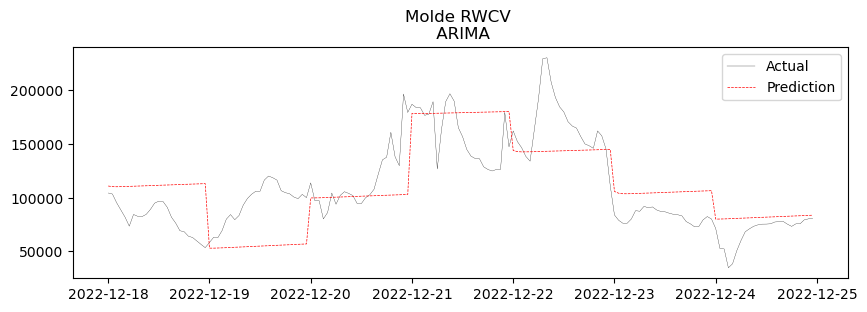

In [39]:

train_set.index.freq = 'H'

shifted_index = train_set.index[-24*13:-24*6]

# Plot the data
plt.figure(figsize=(10, 3))
plt.plot(shifted_index.values, train_set['Price'][(-24*13):(-24*6)].values, label='Actual', linewidth=0.2,  c='black')
plt.plot(shifted_index.values, forecast[(-24*13):(-24*6)], label='Prediction', linewidth=0.5, linestyle='--', c='r')
plt.title('Molde RWCV \n ARIMA')
plt.legend()
plt.show()



In [40]:
# Calculate and print errors

# compute the residuals
residuals = train_set['Target'][365*24*2:].values - val_preds

# compute the RSS
rss = np.sum(residuals**2)

print("Residual Sum of Squares (RSS): ", rss)
print("Mean RMSE:", np.mean(rmse))
print("Mean MAPE:", np.mean(mape))
print("Mean MAE:", np.mean(mae))

Residual Sum of Squares (RSS):  6.000145091258774e+17
Mean RMSE: 22587.009922586407
Mean MAPE: inf
Mean MAE: 18878.897159137254


In [41]:
morning_mask = (train_set.iloc[-365*24:].index.hour >= 6) & (train_set.iloc[-365*24:].index.hour < 12)
midday_mask = (train_set.iloc[-365*24:].index.hour >= 12) & (train_set.iloc[-365*24:].index.hour < 15)
evening_mask = (train_set.iloc[-365*24:].index.hour >= 15) & (train_set.iloc[-365*24:].index.hour < 21)
night_mask = (train_set.iloc[-365*24:].index.hour >= 21) | (train_set.iloc[-365*24:].index.hour < 6)

preds=pd.Series(forecast.values, index=train_set.iloc[-365*24:].index.values)
actual= pd.Series(train_set.iloc[-365*24:]['Target'].values, index=train_set.iloc[-365*24:].index.values)

rmse_morning_scores= np.sqrt(mean_squared_error(actual[morning_mask], preds[morning_mask]))
rmse_morning_scores

rmse_midday_scores= np.sqrt(mean_squared_error(actual[midday_mask], preds[midday_mask]))
rmse_midday_scores

rmse_evening_scores= np.sqrt(mean_squared_error(actual[evening_mask], preds[evening_mask]))
rmse_evening_scores

rmse_night_scores= np.sqrt(mean_squared_error(actual[night_mask], preds[night_mask]))
rmse_night_scores

rmse_scores=pd.Series((rmse_morning_scores,rmse_midday_scores,rmse_evening_scores, rmse_night_scores))


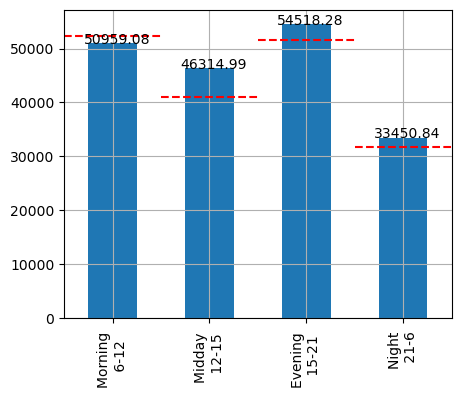

In [42]:
rmse_scores.plot(kind='bar', figsize=(5,4), grid=True)
plt.xticks(ticks=(0, 1, 2, 3), labels=('Morning \n 6-12', 'Midday \n 12-15', 'Evening \n 15-21', 'Night \n 21-6'))

# Annotate the RMSE scores on the bar chart
for i, v in enumerate(rmse_scores):
    plt.annotate(str(round(v,2)), xy=(i-0.3, v))
    
for i, v in enumerate(rmse_scores):
    if i == 0:
        plt.axhline(y=52421, color='r', linestyle='--', xmin=i / len(rmse_scores), xmax=(i + 1) / len(rmse_scores))
    elif i == 1:
        plt.axhline(y=40960, color='r', linestyle='--', xmin=i / len(rmse_scores), xmax=(i + 1) / len(rmse_scores))
    elif i == 2:
        plt.axhline(y=51591, color='r', linestyle='--', xmin=i / len(rmse_scores), xmax=(i + 1) / len(rmse_scores))
    elif i == 3:
        plt.axhline(y=31776, color='r', linestyle='--', xmin=i / len(rmse_scores), xmax=(i + 1) / len(rmse_scores))
    

plt.show()

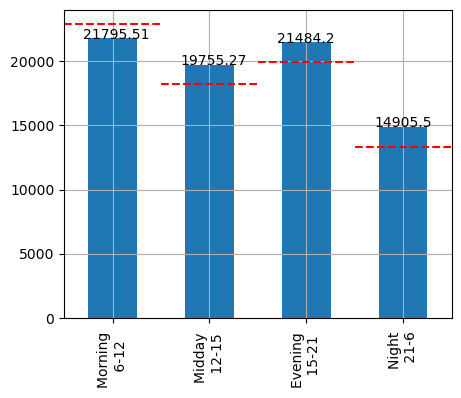

In [43]:

mae_morning_scores = mean_absolute_error(actual[morning_mask], preds[morning_mask])
mae_midday_scores = mean_absolute_error(actual[midday_mask], preds[midday_mask])
mae_evening_scores = mean_absolute_error(actual[evening_mask], preds[evening_mask])
mae_night_scores = mean_absolute_error(actual[night_mask], preds[night_mask])

mae_scores = pd.Series((mae_morning_scores, mae_midday_scores, mae_evening_scores, mae_night_scores))


mae_scores.plot(kind='bar', figsize=(5,4), grid=True)
plt.xticks(ticks=(0, 1, 2, 3), labels=('Morning \n 6-12', 'Midday \n 12-15', 'Evening \n 15-21', 'Night \n 21-6'))

# Annotate the RMSE scores on the bar chart
for i, v in enumerate(mae_scores):
    plt.annotate(str(round(v,2)), xy=(i-0.3, v))
    
for i, v in enumerate(mae_scores):
    if i == 0:
        plt.axhline(y=22891, color='r', linestyle='--', xmin=i / len(mae_scores), xmax=(i + 1) / len(mae_scores))
    elif i == 1:
        plt.axhline(y=18225, color='r', linestyle='--', xmin=i / len(mae_scores), xmax=(i + 1) / len(mae_scores))
    elif i == 2:
        plt.axhline(y=19937, color='r', linestyle='--', xmin=i / len(mae_scores), xmax=(i + 1) / len(mae_scores))
    elif i == 3:
        plt.axhline(y=13290, color='r', linestyle='--', xmin=i / len(mae_scores), xmax=(i + 1) / len(mae_scores))


plt.show()

RMSE: 30448.7269, MAPE: 37.5774% , MAE:  21069.2162, RSS:  2002589934552.9941


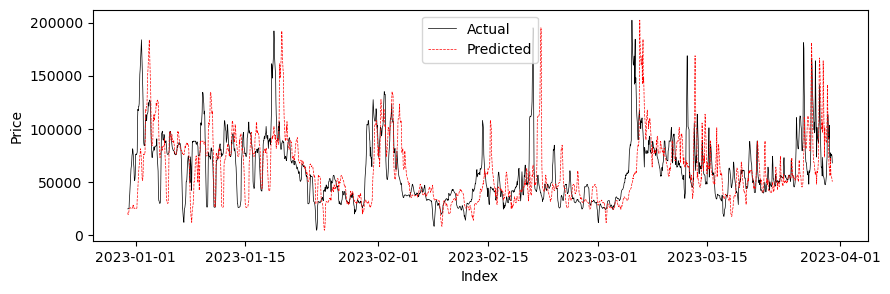

In [44]:
model = sm.tsa.statespace.SARIMAX(train_X, exog=train_X, 
                                  order=(2, 1, 2),
                                  enforce_stationarity=False,
                                  enforce_invertibility=False)
results = model.fit(disp=False)
preds = results.forecast(steps=len(test_X), exog=test_X)


# invert scaling to get unscaled predictions
preds = preds.reshape(-1, 1)
preds = scaler_y.inverse_transform(preds)

test_y = np.array(test_y).reshape(-1, 1)
test_y = scaler_y.inverse_transform(test_y)

# calculate RMSE and MAPE
rmse = np.sqrt(mean_squared_error(test_y, preds))
mape = np.mean(np.abs((test_y - preds) / test_y)) * 100
mae= mean_absolute_error(test_y, preds)

# compute the residuals
residuals = test_y - preds

# compute the RSS
rss = np.sum(residuals**2)

print(f'RMSE: {rmse:.4f}, MAPE: {mape:.4f}% , MAE: {mae: .4f}, RSS: {rss: .4f}')

# plot actual vs predicted values
plt.figure(figsize=(10, 3))
plt.plot(test_set.index, test_y, label='Actual', linewidth=0.5, c='black')
plt.plot(test_set.index, preds, label='Predicted', linewidth=0.5, linestyle='--', c='r')

plt.xlabel('Index')
plt.ylabel('Price')
plt.legend()
plt.show()


# Tr.heim

In [45]:
train_X, train_y, test_X, test_y, scaler_X, scaler_y,  train_set, test_set =prepare_data('Tr.heim')

In [46]:
train_X

array([[-0.90148957],
       [-0.90253844],
       [-0.90429087],
       ...,
       [-0.91317566],
       [-0.91351775],
       [-0.91413094]])

In [47]:
import warnings
warnings.filterwarnings("ignore")
from sklearn.model_selection import TimeSeriesSplit

tscv = TimeSeriesSplit(n_splits=365, test_size=24)
val_preds=[]
rmse=[]
mape=[]
mae=[]
forecast=pd.Series()
for train_index, val_index in tqdm(tscv.split(train_X)):
    X_train, X_val = train_X[train_index], train_X[val_index]
    y_val = train_y[val_index]
    model = sm.tsa.statespace.SARIMAX(X_train,
                                      order=(2, 0, 1),
                                      enforce_stationarity=False,
                                      enforce_invertibility=False)
    results = model.fit(disp=False)
    preds = results.forecast(steps=len(X_val))

    # invert scaling to get unscaled predictions
    preds = preds.reshape(-1, 1)
    preds = scaler_y.inverse_transform(preds)

    y_val = np.array(y_val).reshape(-1, 1)
    y_val = scaler_y.inverse_transform(y_val)
    
    forecast = pd.concat([forecast, pd.Series(preds.ravel())])
    val_preds.append(preds)
    mape.append(np.mean(np.abs((y_val - preds) / y_val)) * 100)
    rmse.append(np.sqrt(mean_squared_error(y_val, preds)))
    mae.append(mean_absolute_error(y_val, preds))

365it [07:07,  1.17s/it]


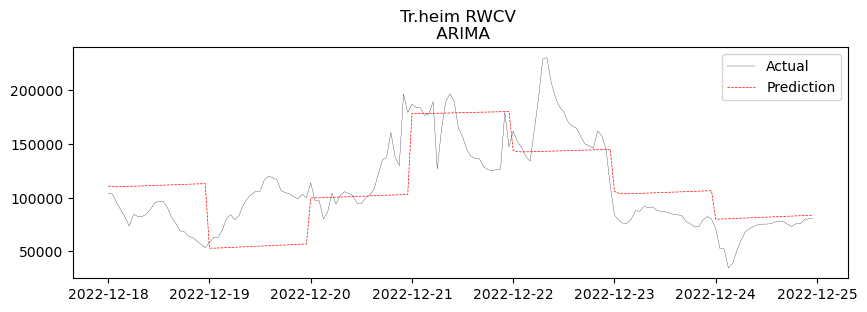

In [48]:

train_set.index.freq = 'H'

shifted_index = train_set.index[-24*13:-24*6]

# Plot the data
plt.figure(figsize=(10, 3))
plt.plot(shifted_index.values, train_set['Price'][(-24*13):(-24*6)].values, label='Actual', linewidth=0.2,  c='black')
plt.plot(shifted_index.values, forecast[(-24*13):(-24*6)], label='Prediction', linewidth=0.5, linestyle='--', c='r')
plt.title('Tr.heim RWCV \n ARIMA')
plt.legend()
plt.show()



In [49]:
# Calculate and print errors

# compute the residuals
residuals = train_set['Target'][365*24*2:].values - val_preds

# compute the RSS
rss = np.sum(residuals**2)

print("Residual Sum of Squares (RSS): ", rss)
print("Mean RMSE:", np.mean(rmse))
print("Mean MAPE:", np.mean(mape))
print("Mean MAE:", np.mean(mae))

Residual Sum of Squares (RSS):  6.000145091258774e+17
Mean RMSE: 22587.009922586407
Mean MAPE: inf
Mean MAE: 18878.897159137254


In [50]:
morning_mask = (train_set.iloc[-365*24:].index.hour >= 6) & (train_set.iloc[-365*24:].index.hour < 12)
midday_mask = (train_set.iloc[-365*24:].index.hour >= 12) & (train_set.iloc[-365*24:].index.hour < 15)
evening_mask = (train_set.iloc[-365*24:].index.hour >= 15) & (train_set.iloc[-365*24:].index.hour < 21)
night_mask = (train_set.iloc[-365*24:].index.hour >= 21) | (train_set.iloc[-365*24:].index.hour < 6)

preds=pd.Series(forecast.values, index=train_set.iloc[-365*24:].index.values)
actual= pd.Series(train_set.iloc[-365*24:]['Target'].values, index=train_set.iloc[-365*24:].index.values)

rmse_morning_scores= np.sqrt(mean_squared_error(actual[morning_mask], preds[morning_mask]))
rmse_morning_scores

rmse_midday_scores= np.sqrt(mean_squared_error(actual[midday_mask], preds[midday_mask]))
rmse_midday_scores

rmse_evening_scores= np.sqrt(mean_squared_error(actual[evening_mask], preds[evening_mask]))
rmse_evening_scores

rmse_night_scores= np.sqrt(mean_squared_error(actual[night_mask], preds[night_mask]))
rmse_night_scores

rmse_scores=pd.Series((rmse_morning_scores,rmse_midday_scores,rmse_evening_scores, rmse_night_scores))


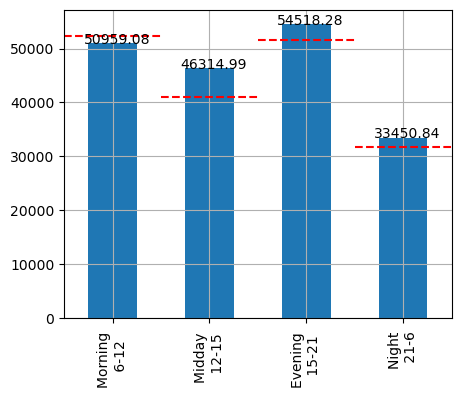

In [51]:
rmse_scores.plot(kind='bar', figsize=(5,4), grid=True)
plt.xticks(ticks=(0, 1, 2, 3), labels=('Morning \n 6-12', 'Midday \n 12-15', 'Evening \n 15-21', 'Night \n 21-6'))

# Annotate the RMSE scores on the bar chart
for i, v in enumerate(rmse_scores):
    plt.annotate(str(round(v,2)), xy=(i-0.3, v))
    
for i, v in enumerate(rmse_scores):
    if i == 0:
        plt.axhline(y=52421, color='r', linestyle='--', xmin=i / len(rmse_scores), xmax=(i + 1) / len(rmse_scores))
    elif i == 1:
        plt.axhline(y=40960, color='r', linestyle='--', xmin=i / len(rmse_scores), xmax=(i + 1) / len(rmse_scores))
    elif i == 2:
        plt.axhline(y=51591, color='r', linestyle='--', xmin=i / len(rmse_scores), xmax=(i + 1) / len(rmse_scores))
    elif i == 3:
        plt.axhline(y=31766, color='r', linestyle='--', xmin=i / len(rmse_scores), xmax=(i + 1) / len(rmse_scores))
    
    

plt.show()

In [52]:
mae_morning_scores = mean_absolute_error(actual[morning_mask], preds[morning_mask])
mae_midday_scores = mean_absolute_error(actual[midday_mask], preds[midday_mask])
mae_evening_scores = mean_absolute_error(actual[evening_mask], preds[evening_mask])
mae_night_scores = mean_absolute_error(actual[night_mask], preds[night_mask])

mae_scores = pd.Series((mae_morning_scores, mae_midday_scores, mae_evening_scores, mae_night_scores))


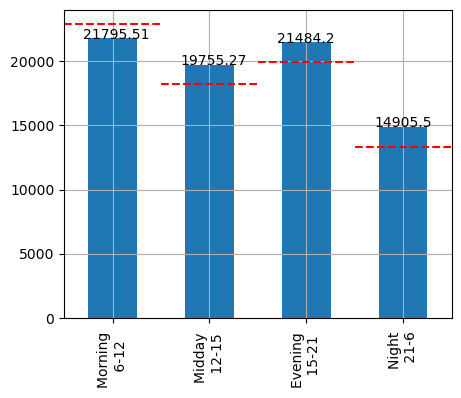

In [53]:
mae_scores.plot(kind='bar', figsize=(5,4), grid=True)
plt.xticks(ticks=(0, 1, 2, 3), labels=('Morning \n 6-12', 'Midday \n 12-15', 'Evening \n 15-21', 'Night \n 21-6'))

# Annotate the RMSE scores on the bar chart
for i, v in enumerate(mae_scores):
    plt.annotate(str(round(v,2)), xy=(i-0.3, v))

for i, v in enumerate(mae_scores):
    if i == 0:
        plt.axhline(y=22891, color='r', linestyle='--', xmin=i / len(mae_scores), xmax=(i + 1) / len(mae_scores))
    elif i == 1:
        plt.axhline(y=18225, color='r', linestyle='--', xmin=i / len(mae_scores), xmax=(i + 1) / len(mae_scores))
    elif i == 2:
        plt.axhline(y=19937, color='r', linestyle='--', xmin=i / len(mae_scores), xmax=(i + 1) / len(mae_scores))
    elif i == 3:
        plt.axhline(y=13290, color='r', linestyle='--', xmin=i / len(mae_scores), xmax=(i + 1) / len(mae_scores))



plt.show()

RMSE: 30448.7269, MAPE: 37.5774% , MAE:  21069.2162, RSS:  2002589934552.9941


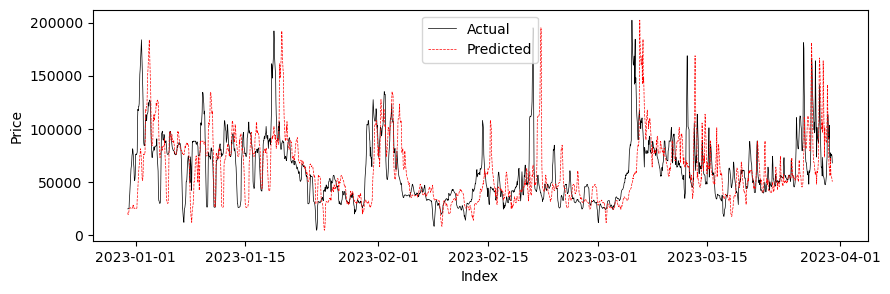

In [54]:
model = sm.tsa.statespace.SARIMAX(train_X, exog=train_X, 
                                  order=(2, 1, 2),
                                  enforce_stationarity=False,
                                  enforce_invertibility=False)
results = model.fit(disp=False)
preds = results.forecast(steps=len(test_X), exog=test_X)


# invert scaling to get unscaled predictions
preds = preds.reshape(-1, 1)
preds = scaler_y.inverse_transform(preds)

test_y = np.array(test_y).reshape(-1, 1)
test_y = scaler_y.inverse_transform(test_y)

# calculate RMSE and MAPE
rmse = np.sqrt(mean_squared_error(test_y, preds))
mape = np.mean(np.abs((test_y - preds) / test_y)) * 100
mae= mean_absolute_error(test_y, preds)

# compute the residuals
residuals = test_y - preds

# compute the RSS
rss = np.sum(residuals**2)

print(f'RMSE: {rmse:.4f}, MAPE: {mape:.4f}% , MAE: {mae: .4f}, RSS: {rss: .4f}')

# plot actual vs predicted values
plt.figure(figsize=(10, 3))
plt.plot(test_set.index, test_y, label='Actual', linewidth=0.5, c='black')
plt.plot(test_set.index, preds, label='Predicted', linewidth=0.5, linestyle='--', c='r')

plt.xlabel('Index')
plt.ylabel('Price')
plt.legend()
plt.show()



# Tromsø

In [55]:
train_X, train_y, test_X, test_y, scaler_X, scaler_y,  train_set, test_set =prepare_data('TromsÃ¸')

In [56]:
train_X

array([[-0.88983607],
       [-0.89105201],
       [-0.89308356],
       ...,
       [-0.90338349],
       [-0.90378007],
       [-0.90744659]])

In [57]:
import warnings
warnings.filterwarnings("ignore")
from sklearn.model_selection import TimeSeriesSplit

tscv = TimeSeriesSplit(n_splits=365, test_size=24)
val_preds=[]
rmse=[]
mape=[]
mae=[]
forecast=pd.Series()
for train_index, val_index in tqdm(tscv.split(train_X)):
    X_train, X_val = train_X[train_index], train_X[val_index]
    y_val = train_y[val_index]
    model = sm.tsa.statespace.SARIMAX(X_train,
                                      order=(2, 0, 1),
                                      enforce_stationarity=False,
                                      enforce_invertibility=False)
    results = model.fit(disp=False)
    preds = results.forecast(steps=len(X_val))

    # invert scaling to get unscaled predictions
    preds = preds.reshape(-1, 1)
    preds = scaler_y.inverse_transform(preds)

    y_val = np.array(y_val).reshape(-1, 1)
    y_val = scaler_y.inverse_transform(y_val)
    
    forecast = pd.concat([forecast, pd.Series(preds.ravel())])
    val_preds.append(preds)
    mape.append(np.mean(np.abs((y_val - preds) / y_val)) * 100)
    rmse.append(np.sqrt(mean_squared_error(y_val, preds)))
    mae.append(mean_absolute_error(y_val, preds))

365it [09:15,  1.52s/it]


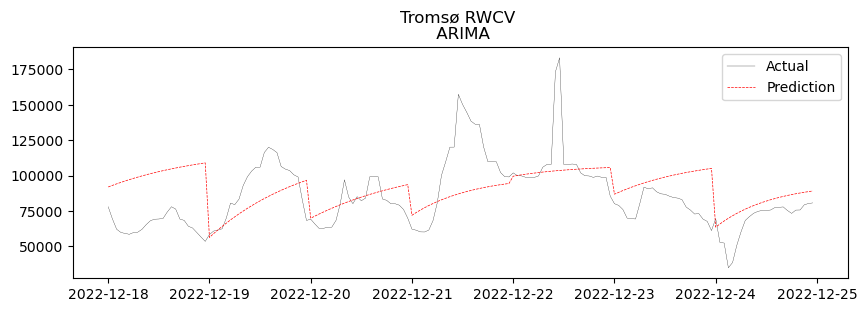

In [58]:

train_set.index.freq = 'H'

shifted_index = train_set.index[-24*13:-24*6]

# Plot the data
plt.figure(figsize=(10, 3))
plt.plot(shifted_index.values, train_set['Price'][(-24*13):(-24*6)].values, label='Actual', linewidth=0.2,  c='black')
plt.plot(shifted_index.values, forecast[(-24*13):(-24*6)], label='Prediction', linewidth=0.5, linestyle='--', c='r')
plt.title('Tromsø RWCV \n ARIMA')
plt.legend()
plt.show()


In [59]:
# Calculate and print errors

# compute the residuals
residuals = train_set['Target'][365*24*2:].values - val_preds

# compute the RSS
rss = np.sum(residuals**2)

print("Residual Sum of Squares (RSS): ", rss)
print("Mean RMSE:", np.mean(rmse))
print("Mean MAPE:", np.mean(mape))
print("Mean MAE:", np.mean(mae))

Residual Sum of Squares (RSS):  1.9104187956908003e+17
Mean RMSE: 13169.259816130838
Mean MAPE: inf
Mean MAE: 11019.919383542252


In [60]:
morning_mask = (train_set.iloc[-365*24:].index.hour >= 6) & (train_set.iloc[-365*24:].index.hour < 12)
midday_mask = (train_set.iloc[-365*24:].index.hour >= 12) & (train_set.iloc[-365*24:].index.hour < 15)
evening_mask = (train_set.iloc[-365*24:].index.hour >= 15) & (train_set.iloc[-365*24:].index.hour < 21)
night_mask = (train_set.iloc[-365*24:].index.hour >= 21) | (train_set.iloc[-365*24:].index.hour < 6)

preds=pd.Series(forecast.values, index=train_set.iloc[-365*24:].index.values)
actual= pd.Series(train_set.iloc[-365*24:]['Target'].values, index=train_set.iloc[-365*24:].index.values)

rmse_morning_scores= np.sqrt(mean_squared_error(actual[morning_mask], preds[morning_mask]))
rmse_morning_scores

rmse_midday_scores= np.sqrt(mean_squared_error(actual[midday_mask], preds[midday_mask]))
rmse_midday_scores

rmse_evening_scores= np.sqrt(mean_squared_error(actual[evening_mask], preds[evening_mask]))
rmse_evening_scores

rmse_night_scores= np.sqrt(mean_squared_error(actual[night_mask], preds[night_mask]))
rmse_night_scores

rmse_scores=pd.Series((rmse_morning_scores,rmse_midday_scores,rmse_evening_scores, rmse_night_scores))


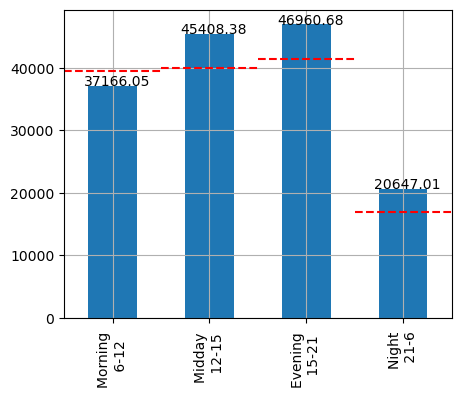

In [61]:
rmse_scores.plot(kind='bar', figsize=(5,4), grid=True)
plt.xticks(ticks=(0, 1, 2, 3), labels=('Morning \n 6-12', 'Midday \n 12-15', 'Evening \n 15-21', 'Night \n 21-6'))

# Annotate the RMSE scores on the bar chart
for i, v in enumerate(rmse_scores):
    plt.annotate(str(round(v,2)), xy=(i-0.3, v))

for i, v in enumerate(rmse_scores):
    if i == 0:
        plt.axhline(y=39456, color='r', linestyle='--', xmin=i / len(rmse_scores), xmax=(i + 1) / len(rmse_scores))
    elif i == 1:
        plt.axhline(y=40010, color='r', linestyle='--', xmin=i / len(rmse_scores), xmax=(i + 1) / len(rmse_scores))
    elif i == 2:
        plt.axhline(y=41405, color='r', linestyle='--', xmin=i / len(rmse_scores), xmax=(i + 1) / len(rmse_scores))
    elif i == 3:
        plt.axhline(y=16851, color='r', linestyle='--', xmin=i / len(rmse_scores), xmax=(i + 1) / len(rmse_scores))
    

plt.show()

In [62]:
mae_morning_scores = mean_absolute_error(actual[morning_mask], preds[morning_mask])
mae_midday_scores = mean_absolute_error(actual[midday_mask], preds[midday_mask])
mae_evening_scores = mean_absolute_error(actual[evening_mask], preds[evening_mask])
mae_night_scores = mean_absolute_error(actual[night_mask], preds[night_mask])

mae_scores = pd.Series((mae_morning_scores, mae_midday_scores, mae_evening_scores, mae_night_scores))


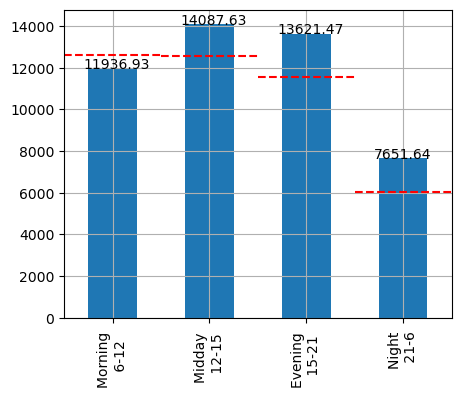

In [63]:
mae_scores.plot(kind='bar', figsize=(5,4), grid=True)
plt.xticks(ticks=(0, 1, 2, 3), labels=('Morning \n 6-12', 'Midday \n 12-15', 'Evening \n 15-21', 'Night \n 21-6'))

# Annotate the RMSE scores on the bar chart
for i, v in enumerate(mae_scores):
    plt.annotate(str(round(v,2)), xy=(i-0.3, v))
    
for i, v in enumerate(mae_scores):
    if i == 0:
        plt.axhline(y=12597, color='r', linestyle='--', xmin=i / len(mae_scores), xmax=(i + 1) / len(mae_scores))
    elif i == 1:
        plt.axhline(y=12547, color='r', linestyle='--', xmin=i / len(mae_scores), xmax=(i + 1) / len(mae_scores))
    elif i == 2:
        plt.axhline(y=11571, color='r', linestyle='--', xmin=i / len(mae_scores), xmax=(i + 1) / len(mae_scores))
    elif i == 3:
        plt.axhline(y=6047, color='r', linestyle='--', xmin=i / len(mae_scores), xmax=(i + 1) / len(mae_scores))


plt.show()

RMSE: 21456.2124, MAPE: 25.2771% , MAE:  11705.3764, RSS:  994397149796.9965


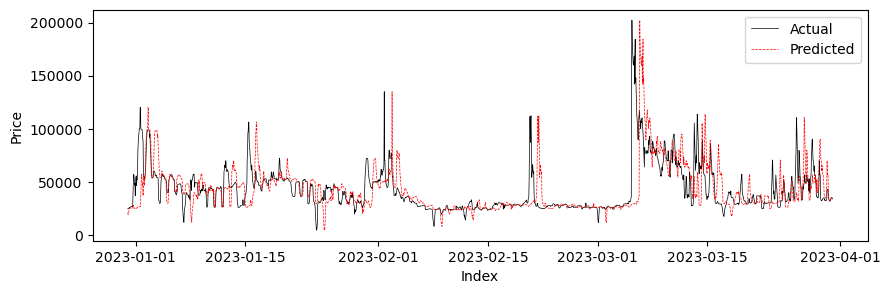

In [64]:
model = sm.tsa.statespace.SARIMAX(train_X, exog=train_X, 
                                  order=(2, 1, 2),
                                  enforce_stationarity=False,
                                  enforce_invertibility=False)
results = model.fit(disp=False)
preds = results.forecast(steps=len(test_X), exog=test_X)


# invert scaling to get unscaled predictions
preds = preds.reshape(-1, 1)
preds = scaler_y.inverse_transform(preds)

test_y = np.array(test_y).reshape(-1, 1)
test_y = scaler_y.inverse_transform(test_y)

# calculate RMSE and MAPE
rmse = np.sqrt(mean_squared_error(test_y, preds))
mape = np.mean(np.abs((test_y - preds) / test_y)) * 100
mae= mean_absolute_error(test_y, preds)

# compute the residuals
residuals = test_y - preds

# compute the RSS
rss = np.sum(residuals**2)


print(f'RMSE: {rmse:.4f}, MAPE: {mape:.4f}% , MAE: {mae: .4f}, RSS: {rss: .4f}')

# plot actual vs predicted values
plt.figure(figsize=(10, 3))
plt.plot(test_set.index, test_y, label='Actual', linewidth=0.5, c='black')
plt.plot(test_set.index, preds, label='Predicted', linewidth=0.5, linestyle='--', c='r')

plt.xlabel('Index')
plt.ylabel('Price')
plt.legend()
plt.show()
